https://github.com/oekosheri/Recommender-movie/blob/master/Recom_walk_through.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [3]:
#Load movies data
movies = pd.read_csv('ml-20m/movies.csv')
genome_scores = pd.read_csv('ml-20m/genome-scores.csv')
tags = pd.read_csv('ml-20m/tags.csv')
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('ml-20m/ratings.csv')
#ratings = ratings.drop_duplicates('movieId')

In [14]:
len(movies.movieId.unique())

27278

In [15]:
len(ratings.movieId.unique())

26744

In [4]:
#limit ratings to user ratings that have rated more that 55 movies -- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [17]:
# no worries: we have kept 97% of the original movie titles in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

97.85908057775497

In [18]:
# but only 57% of the users 
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

57.797867040211415

In [5]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [20]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [12]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [6]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

/Users/chenlujia/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
# create a mixed dataframe of movies title, genres 
# and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,Disney animated feature


In [24]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(26694, 23704)


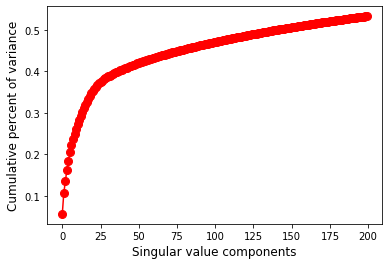

In [26]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [27]:
#number of latent dimensions to keep
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [28]:
# our content latent matrix:
latent_matrix.shape

(26694, 200)

In [29]:
ratings_f.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [30]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [31]:
ratings_f1.head()

,movieId,userId,rating
0,1,3,4.0
1,1,8,4.0
2,1,11,4.5
3,1,13,4.0
4,1,14,4.5


In [32]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [33]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,...,138474,138475,138477,138483,138484,138486,138487,138490,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,...,5.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,3.5
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,4.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,4.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [34]:
len(ratings_f.movieId.unique())

26694

In [ ]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Strada, La (1954)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Strada, La (1954)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

In [8]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [9]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.7727


0.7727147042594004

In [16]:
ratings_f.userId.unique()

array([     1,      2,      3, ..., 138490, 138492, 138493])

In [13]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [14]:
user_id = 7020
pred_user_rating(user_id)

,ratings
movies,
"Celebration, The (Festen) (1998)",4.796972
Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.790707
"Century of the Self, The (2002)",4.760498
"Sorrow and the Pity, The (Le chagrin et la pitié) (1969)",4.740084
North & South (2004),4.739286
Stalker (1979),4.734083
Alone in the Wilderness (2004),4.731239
Before Sunset (2004),4.728691
Fawlty Towers (1975-1979),4.727714


In [24]:
ratings_f.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [22]:
X = ratings_f[['userId', 'movieId']]
y = ratings_f['rating']

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [25]:
kn = KNeighborsClassifier()
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
kn.fit(X_train, y_train_encoded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
kn.predict(X_test)

In [ ]:
kn2 = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
kn2.fit(ratings_f2)

In [ ]:

movie = ratings_f2[1].values.reshape(1,-1)
kn2.kneighbors(movie, n_neighbors = 5)

In [ ]:
ratings_f2.shape


In [17]:
import os
from fuzzywuzzy import fuzz
from scipy.sparse import csr_matrix

/Users/chenlujia/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [18]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True
    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [38]:
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie
    Parameters
    ----------
    model_knn: sklearn model, knn model
    data: movie-user matrix
    mapper: dict, map movie title name to index of the movie in data
    fav_movie: str, name of user input movie
    n_recommendations: int, top n recommendations
    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =         sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [19]:
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1)
# fit
movie_user_mat_sparse = csr_matrix(ratings_f2.values)
model_knn.fit(movie_user_mat_sparse)

NameError: name 'NearestNeighbors' is not defined

In [48]:
#map movie titles to images
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[ratings_f2.index].title))
}

my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'My Own Man', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: V for Vendetta (2006), with distance of 0.44794156447133293
2: 300 (2007), with distance of 0.4447485855447141
3: Iron Man 2 (2010), with distance of 0.4384174540492918
4: Casino Royale (2006), with distance of 0.4265617822228156
5: Avatar (2009), with distance of 0.4236529916585877
6: Bourne Ultimatum, The (2007), with distance of 0.4176138274547305
7: Batman Begins (2005), with distance of 0.4115736314126439
8: WALL·E (2008), with distance of 0.3894567576120107
9: Star Trek (2009), with distance of 0.3827194003136396
10: Dark Knight, The (2008), with distance of 0.3023875052563828


In [49]:
movie_to_idx

{'Toy Story (1995)': 0,
 'Jumanji (1995)': 1,
 'Grumpier Old Men (1995)': 2,
 'Waiting to Exhale (1995)': 3,
 'Father of the Bride Part II (1995)': 4,
 'Heat (1995)': 5,
 'Sabrina (1995)': 6,
 'Tom and Huck (1995)': 7,
 'Sudden Death (1995)': 8,
 'GoldenEye (1995)': 9,
 'American President, The (1995)': 10,
 'Dracula: Dead and Loving It (1995)': 11,
 'Balto (1995)': 12,
 'Nixon (1995)': 13,
 'Cutthroat Island (1995)': 14,
 'Casino (1995)': 15,
 'Sense and Sensibility (1995)': 16,
 'Four Rooms (1995)': 17,
 'Ace Ventura: When Nature Calls (1995)': 18,
 'Money Train (1995)': 19,
 'Get Shorty (1995)': 20,
 'Copycat (1995)': 21,
 'Assassins (1995)': 22,
 'Powder (1995)': 23,
 'Leaving Las Vegas (1995)': 24,
 'Othello (1995)': 25,
 'Now and Then (1995)': 26,
 'Persuasion (1995)': 27,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 28,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 29,
 'Dangerous Minds (1995)': 30,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)': 